# **Übung 6: Wirbelleiterverfahren**

In [460]:
# Importieren von Python-Biblioteken
import numpy as np
import matplotlib.pyplot as plt
from blume import table
import pandas as pd
from ipywidgets import IntSlider, fixed, VBox, HBox, Label
import ipywidgets as widgets
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from numba import jit

# Erhöhen der Plot-Auflösung
plt.rcParams["figure.dpi"] = 140

### 6.1.1 Visualisierung Pfeilflügel

In [461]:
def pfeilfluegel(s, phi, c=1) -> np.array:
    """Generiert die Planform eines gepfeilten Rechteckflügels auf Basis der Spannweite und Pfeilung"""
    shift = s * np.tan(np.radians(phi))

    # Definition aller Eckpunkte
    points = np.array([
        [0, 0], [s, shift], [s, c + shift], [0, c], 
        [-s, c + shift], [-s, shift], [0, 0]])
    
    return points


def plot_pfeilfluegel(s, phi):
    """Plottet die Planform eines gepfeilten Rechteckflügels auf Basis der Spannweite und Pfeilung"""
    
    # Flügeleckpunkte generieren
    points = pfeilfluegel(s, phi)

    # Geometrie plotten
    plt.figure(figsize=(7, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Pfeilflügel')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()


def widget_pfeilfluegel():
    """Erzeugt ein widget, mit dem sich die Planform eines gepfeilten Rechteckflügels interaktiv visualisieren lässt"""

    slider_s = VBox([Label('Halbspannweite [m]'), IntSlider(value=3, min=1, max=20)])
    slider_phi = VBox([Label('Pfeilwinkel [deg]'), IntSlider(value=15, min=0, max=60)])

    # Interaktiver plot
    ui = VBox([slider_s, slider_phi])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_pfeilfluegel, {'s': slider_s.children[1], 'phi': slider_phi.children[1]})

    return HBox([out, ui])

In [462]:
display(widget_pfeilfluegel())

### 6.1.2 Geometrische Parameter und Randbedinungen

In [463]:
# Konstant
phi = np.radians(15)        # Pfeilungswinkel (in rad)
b = 15                      # Spannweite
s = b/2                     # Halbspannweite
AR = 12                     # Streckung
U_inf = 30                  # Anströmgeschwindigkeit (in m/s)
alpha = np.radians(5)       # Anstellwinkel (in rad)
rho = 1                     # Luftdichte (in kg/m^3)
k_Gamma = 0.25              # Skalierung der Wirbelposition
k_A = 0.75                  # Skalierung des Aufpunkts
c = b/ AR                   # Flügeltiefe
S = b*c                     # Flügelfläche

### 6.1.3 Vernetzen des Tragflügels

In [464]:
def plot_diskretisierung_pfeil(N, M, s=3, c=1):
    """Plottet die Diskretisierung eines gepfeilten Rechteckflügels auf Basis der Anzahl der Elementarflügel"""

    points = pfeilfluegel(s, np.degrees(phi))
    
    # Diskretisierung der Halbspannweite
    y_values = np.linspace(-s, s, N+1)
    x_values = np.linspace(0, c, M+1)
    
    # Geometrie plotten
    plt.figure(figsize=(6, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")

    # Panele plotten
    for i in range(N+1):
        shift = abs(y_values[i]) * np.tan(phi)
        plt.plot([y_values[i], y_values[i]], [shift, shift + c], 'g-', linewidth=0.5)

    for j in range(M+1):
        plt.plot([-s, 0, s], [x_values[j] + shift, x_values[j], x_values[j] + shift], 'g-', linewidth=0.5)
    
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Diskretisierung Pfeilflügel')
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()


def widget_diskretisierung_pfeil():
    """Erzeugt ein widget, mit dem sich die Diskretisierung eines gepfeilten Rechteckflügels interaktiv visualisieren lässt"""

    slider_N = VBox([Label('Anzahl horizontaler Panele'), IntSlider(value=20, min=1, max=100)])
    slider_M = VBox([Label('Anzahl vertikaler Panele'), IntSlider(value=5, min=1, max=60)])

    # Interaktiver plot
    ui = VBox([slider_N, slider_M])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_diskretisierung_pfeil, {'N': slider_N.children[1], 'M': slider_M.children[1]})
    return HBox([out, ui])

In [465]:
display(widget_diskretisierung_pfeil())

# 🟠

In [466]:
# Diese Parameter können verändert werden
N = 60                      # Anzahl horizontaler Panele
M = 20                       # Anzahl vertikaler Panele

# Berechne Paneldimensionen, chord ergibt sich aus der Flügelbreite und gegebenen Streckung
c = b/AR        
Delta_y = b / N
Delta_x = c / M

### 6.1.4 Berechnung der Panelpunkte A, B und C

In [467]:
# @jit ist ein decorator und gehört zur numba Bibliothek. Bei der ersten Ausführung der Funktion wird der Code in hocheffiziente Maschinensprache übersetzt. 
# Vor allem bei Funktionen mit for-Schleifen kann man den Prozess drastisch beschleunigen
@jit
def compute_coords(s, phi, N, M, c, k_A, k_Gamma):
    """
    Berechnet die Koordinaten der induzierenden Punkte A und B sowie der Aufpunkte C der Panele auf einem gepfeilten Rechteckflügel.
    Die Punkte A und B werden am linken und rechten Rand auf der 1/4 Linie jedes Panels berechnet.
    Die Aufunkte werden mittig auf der 3/4 Linie jedes Panels berechnet.
    """
    
    # Diskretisierung der Halbspannweite und Flügeltiefe
    y_values = np.linspace(-s, s, N+1)
    x_values = np.linspace(0, 1, M+1)
    
    # Berechnung der mittigen Punkte in Spannweiten- und Tiefenrichtung
    y_panel_centers = (y_values[:-1] + y_values[1:]) / 2

    # Arrays für die Koordinaten
    X_A = np.zeros((N, M))
    Y_A = np.zeros((N, M))
    X_B = np.zeros((N, M))
    Y_B = np.zeros((N, M))
    X_C = np.zeros((N, M))
    Y_C = np.zeros((N, M))
    
    for i in range(N):
        for j in range(M):
            # A
            # Shift wegen des Pfeilwinkels (Verschiebung der x-Koordinate entlang der y-Achse)
            shift = abs(y_values[i]) * np.tan(phi)
            X_A[i, j] = shift + x_values[j] + k_Gamma * c / M     # Punkt auf der 1/4 Linie
            Y_A[i, j] = y_values[i]                                 # am linken Rand des Panels

            # B
            shift = abs(abs(y_values[i+1])) * np.tan(phi)
            X_B[i, j] = shift + x_values[j] + k_Gamma * c / M     # Punkt auf der 1/4 Linie
            Y_B[i, j] = y_values[i+1]                               # am rechten Rand des Panels

            # C
            shift = abs(y_panel_centers[i]) * np.tan(phi)
            X_C[i, j] = shift + x_values[j] + k_A * c / M        # Aufpunkt auf der 3/4 Linie
            Y_C[i, j] = y_panel_centers[i]                          # mittig auf dem Panel

    return X_A, Y_A, X_B, Y_B, X_C, Y_C

# Berechnen aller Koordinaten
X_A, Y_A, X_B, Y_B, X_C, Y_C = compute_coords(s, phi, N, M, c, k_A, k_Gamma)

### 6.1.5 Transformation vom (i,j) in das (n) - System

In [468]:
def matrix_to_vector(Mat):
    """ Transformiert ein Koordinatengitter N x M in einen Vektor der Länge N * M. """
    # Transponieren und flach machen (flatten)
    return Mat.T.flatten()

In [469]:
# Transformieren von Matrizen in Vektoren
x_a = matrix_to_vector(X_A)
y_a = matrix_to_vector(Y_A)
x_b = matrix_to_vector(X_B)
y_b = matrix_to_vector(Y_B)
x_c = matrix_to_vector(X_C)
y_c = matrix_to_vector(Y_C)

### 6.1.6 Berechnung der Koeffizientenmatrix

In [470]:
@jit
def compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c, N, M):
    # TODO Auftriebsabfall zu den Flügelenden nicht physikalisch, die Implementierung ist nicht vollständig 
    # (Reproduktion mit bspw. phi = 75deg, 3D Auftriebskurve recovered zu den Flügelenden, daher steigt der Auftrieb wieder ab phi 45deg Pfeilung)
    """Berechnet die drei Anteile der Koeffizientenmatrix"""
    
    # Initialisieren der Matrizen
    a_AB = np.zeros((x_a.size, x_a.size))
    a_Aoo = np.zeros((x_a.size, x_a.size))
    a_Boo = np.zeros((x_a.size, x_a.size))

    # Berechnen der Anteile der gebundenen Wirbel
    for j in range(N*M):
        for i in range(N*M):
            a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

    # Berechnen der Anteile der freien Wirbel der linken Seite
    for j in range(N*M):
        for i in range(N*M):
            a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

    # Berechnen der Anteile der freien Wirbel der rechten Seite
    for j in range(N*M):
        for i in range(N*M):
            a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)
    
    return a_AB, a_Aoo, a_Boo

In [471]:
# Berechnen der Anteile der Koeffizientenmatrix
a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c, N, M)

a = a_AB + a_Aoo - a_Boo                        # Koeffizientenmatrix
a_ind_vec = a_Aoo - a_Boo                       # Koeffizientenmatrix der induzierenden Wirbel
alpha_g_vec = np.full((a.shape[0]), alpha)      # Anstellwinkelvektor

# Löst das lineare Gleichungssystem Ax = b, wobei
# A - Koeffizientenmatrix a
# x - Zirkulationsvektor Gamma
# B - Koeffizientenvektor alpha_g * (- U_inf)   (kinematische Strömungsbedingung)
Gamma_vec = np.linalg.solve(a, alpha_g_vec * (- U_inf)) 

### 6.1.5 Rücktransformation in das (i,j) - System

In [472]:
def vector_to_matrix(vec, N, M):
    """ Transformiert einen Vektor der Länge i*j zurück in ein Koordinatengitter (Matrix) mit Dimensionen i x j. """
    
    if len(vec) != N * M:
        raise ValueError("Die Länge des Vektors passt nicht zu den angegebenen Matrixdimensionen.")
    
    # Zuerst formen wir den Vektor in eine Matrix um
    Mat = np.reshape(vec, (M, N))
    
    # Transponieren, um die ursprüngliche Reihenfolge wiederherzustellen
    Mat = np.transpose(Mat)
    
    return Mat

In [473]:
# Rücktransformation von Vektoren in Matrizen
Gamma = vector_to_matrix(Gamma_vec, N, M)

### 6.1.6 Berechnung von Kräften und Beiwerten
#### Auftrieb

In [474]:
# Berechne Auftrieb für jedes Panel-Element
A = rho * U_inf * Gamma

A_j = np.sum(A, axis=0)     # Auftrieb aufsummiert über die Spannweite
A_i = np.sum(A, axis=1)     # Auftrieb aufsummiert in Flügeltiefe

# Berechne Gesamtzirkulation entlang der Spannweite
Gamma_span = np.sum(Gamma, axis=1)  # Summe entlang der Sehne für jede Spannweitenposition

# Berechne den Gesamtauftrieb
A_ges = rho * U_inf * np.sum(Gamma_span * Delta_y)

# Berechne den Auftriebsbeiwert
C_A = A_ges / (0.5 * rho * U_inf**2 * S)

# Berechne den Auftriebsanstieg
C_A_alpha = C_A / alpha

print("Auftrieb:                    ", "%.2f" % A_ges, "N")
print("Auftriebsbeiwert:            ", "%.4f" % C_A)
print("Auftriebsanstieg:            ", "%.2f" % C_A_alpha)

Auftrieb:                     3627.26 N
Auftriebsbeiwert:             0.4299
Auftriebsanstieg:             4.93


#### Widerstand

In [475]:
# Berechnung des induzierten Widerstands
w_ind_vec = a_ind_vec @ Gamma_vec
w_ind = vector_to_matrix(w_ind_vec, N, M)

# Berechnung des induzierten Widerstands D_ind
W_ind = - rho * U_inf * np.sum(Gamma * w_ind * Delta_y * Delta_x)

# Widerstandsbeiwert (induziert)
C_W_ind = W_ind / (0.5 * rho * U_inf**2 * S)

print("Induzierter Widerstand:      ", "%.2f" % W_ind, "N")
print("Widerstandsbeiwert:          ", "%.4f" % C_W_ind, "N")

Induzierter Widerstand:       63.49 N
Widerstandsbeiwert:           0.0075 N


### 6.1.7 Visualisierung
### 3D-Auftriebsverteilung
Für die Visualisierung wird hier plotly verwendet. Eine andere Möglichkeit zur Visualisierung mit high-level API. Das besondere an plotly ist die Möglichkeit zur Interaktion mit Plots durch Rotation und Zoom, was vor allem bei 3D-Darstellungen sehr hilfreich ist.

In [476]:
def plot_lift_distribution(X_C, Y_C, A):
    """
    Plottet die Auftriebsverteilung  als interaktive 3D-Oberfläche 
    """
    fig = make_subplots(rows=1, cols=2, specs=[[{"type": "surface"}, {"type": "surface"}]],
                        subplot_titles=("Projizierte Auftriebsverteilung", "3D-Auftriebsverteilung"))
    
    # Rechteckiges Punktegitter erzeugen
    x_rect = np.linspace(0, c, M)
    y_rect = np.linspace(-s, s, N)
    XX, YY = np.meshgrid(x_rect, y_rect)

    # Erstelle die projizierte Auftriebsverteilung
    fig.add_trace(go.Surface(
        z=A, x=XX, y=YY,
        colorscale='Turbo',
        name='Flügelgrundriss',
        showscale=False
        ), row=1, col=1)

    # Erstelle die 3D-Auftriebsverteilung
    fig.add_trace(go.Surface(
        z=A, x=X_C, y=Y_C,
        colorscale='Blues',
        name='Flügelgrundriss',
        showscale=False
        ), row=1, col=2)


    # Füge die Flügelplanform als 3D-Linie hinzu
    points = pfeilfluegel(s, np.degrees(phi), c)
    fig.add_trace(go.Scatter3d(
        x=points[:, 1], y=points[:, 0], z=np.zeros(points.shape[0]),
        mode='lines',
        line=dict(color='black', width=10),
        name='3D-Auftriebsverteilung'
        ), row=1, col=2)

    # Entferne die Achsen und Beschriftungen
    fig.update_layout(
        scene2=dict( 
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
        ),
        margin=dict(l=0, r=0, b=50, t=50),  # Ränder einstellen
        width=1000,
        height=500
    )

    # Zeige den Plot an
    fig.show()


# Plot-Funktion ausführen
plot_lift_distribution(X_C, Y_C, A)


### 2D-Auftriebsverteilung

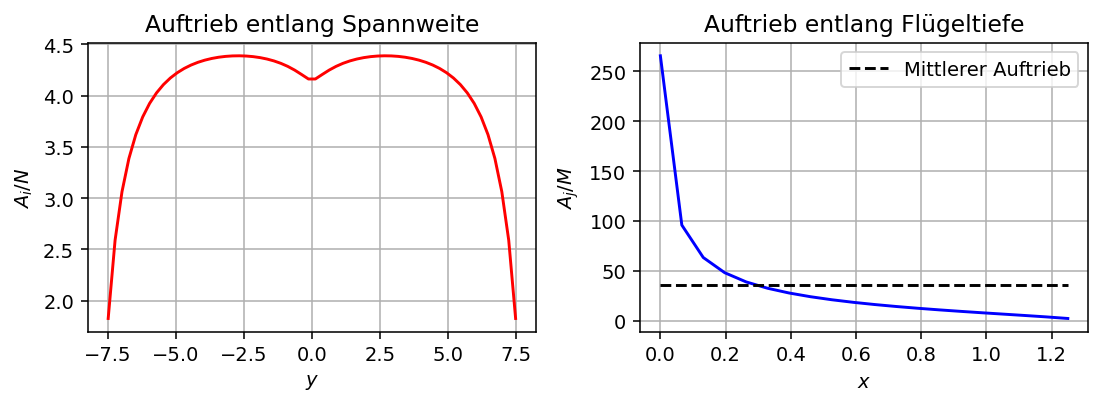

In [477]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(np.linspace(-s, s, N), A_i/N, '-', color="red", label=r"A")
ax1.set_title("Auftrieb entlang Spannweite")
ax1.set_ylabel(r"$A_i / N$")
ax1.set_xlabel(r"$y$")
ax1.grid(True)


ax2.plot(np.linspace(0, c, M), A_j/M, '-', color="blue")
ax2.plot(np.linspace(0, c, M), np.full((A_j.shape), np.mean(A_j/M)), '--', color="black", label="Mittlerer Auftrieb")
ax2.set_title("Auftrieb entlang Flügeltiefe")
ax2.set_ylabel(r"$A_j / M$")
ax2.set_xlabel(r"$x$")
ax2.grid(True)
ax2.legend()

fig.tight_layout()
plt.show()

## **Aufgabe 1 Mitteneffekt von Pfeilflügeln**
Untersuchen Sie für variierende Pfeilungen $\phi$ die Ausbildungen des Mittenffektes bei Pfeilflügeln. Wie verhält sich der lokale Auftriebsverlauf in Flügeltiefenrichtung? Wie unterscheiden sich die Auftriebsverteilungen von zurückgepfeilten (+$\phi$) und vorgepfeilten (-$\phi$) Flügeln. Begründen Sie Ihre Aussagen.

### **Konvergenzstudie**


In [478]:
# Parameter setzen
phi = np.radians(15)        # Pfeilungswinkel (in rad)
b = 15                      # Spannweite
s = b/2                     # Halbspannweite
AR = 12                     # Streckung
c = b / AR                  # Flügeltiefe
U_inf = 30                  # Anströmgeschwindigkeit (in m/s)
alpha = np.radians(5)       # Anstellwinkel (in rad)
S = b*c                     # Flügelfläche

In [479]:
# Iterationsschleife
N_values = [5, 10, 20, 40, 80, 80, 80, 80, 80, 80, 5, 10, 20, 40, 80]
M_values = [5, 10, 20, 40, 80, 5, 10, 20, 40, 80, 80, 80, 80, 80, 80]

results_dict = {
    r"$N$": ["[-]"],
    r"$M$": ["[-]"],
    r"$C_A$": ["[-]"],
    r"$\partial C_A / \partial \alpha$": ["[-]"],
    r"$C_W$": ["[-]"],
    "Rechenzeit": ["[s]"]
}

print("Starting convergence study")
for N, M in zip(N_values, M_values):

    print(f"N={N}, M={M}")
    # Zeit speichern
    start_time = time.time()

    # Paneldimensionen berechnen
    Delta_y = b / N
    Delta_x = c / M

    # Berechnen der Koordinaten und Trafo in Vektoren
    X_A, Y_A, X_B, Y_B, X_C, Y_C = compute_coords(s, phi, N, M, c, k_A, k_Gamma)
    x_a = matrix_to_vector(X_A)
    y_a = matrix_to_vector(Y_A)
    x_b = matrix_to_vector(X_B)
    y_b = matrix_to_vector(Y_B)
    x_c = matrix_to_vector(X_C)
    y_c = matrix_to_vector(Y_C)

    # Berechnen der Anteile der Zikrulationsmatrix
    a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c, N, M)
    a = a_AB + a_Aoo - a_Boo        
    a_ind_vec = a_Aoo - a_Boo
    Gamma_vec = np.linalg.solve(a, np.full((a.shape[0]), alpha) * (- U_inf))
    Gamma = vector_to_matrix(Gamma_vec, N, M)

    # Berechnen von Auftrieb und Auftriebsanstieg
    Gamma_span = np.sum(Gamma, axis=1) 
    A_ges = rho * U_inf * np.sum(Gamma_span * Delta_y)
    C_A = A_ges / (0.5 * rho * U_inf**2 * S)
    C_A_alpha = C_A / alpha

    # Berechnen des indzierten Widerstandes
    w_ind = vector_to_matrix(a_ind_vec @ Gamma_vec, N, M)
    W_ind = - rho * U_inf * np.sum(Gamma * w_ind * Delta_y * Delta_x)
    C_W_ind = W_ind / (0.5 * rho * U_inf**2 * S)

    # Berechne die vergangene Zeit
    elapsed_time = round((time.time() - start_time), 2)

    results_dict[r"$N$"].append(N)
    results_dict[r"$M$"].append(M)
    results_dict[r"$C_A$"].append(round(C_A.item(), 3))
    results_dict[r"$\partial C_A / \partial \alpha$"].append(round(C_A_alpha.item(), 3))
    results_dict[r"$C_W$"].append(round(C_W_ind.item(), 5))
    results_dict["Rechenzeit"].append(elapsed_time)

    print(f"-> took {elapsed_time} s", end="\n \n")

Starting convergence study
N=5, M=5
-> took 0.0 s
 
N=10, M=10
-> took 0.0 s
 
N=20, M=20
-> took 0.01 s
 
N=40, M=40
-> took 0.08 s
 
N=80, M=80
-> took 3.61 s
 
N=80, M=5
-> took 0.02 s
 
N=80, M=10
-> took 0.02 s
 
N=80, M=20
-> took 0.08 s
 
N=80, M=40
-> took 0.52 s
 
N=80, M=80
-> took 3.55 s
 
N=5, M=80
-> took 0.03 s
 
N=10, M=80
-> took 0.03 s
 
N=20, M=80
-> took 0.08 s
 
N=40, M=80
-> took 0.55 s
 
N=80, M=80
-> took 3.68 s
 


In [480]:
# Index vom Referenzwert finden (maximales N und M)
max_index = max(range(1, len(results_dict['$N$'])), key=lambda i: (results_dict['$N$'][i], results_dict['$M$'][i]))
reference_CA = results_dict['$C_A$'][max_index]
reference_CA_alpha = results_dict[r"$\partial C_A / \partial \alpha$"][max_index]
reference_CW = results_dict['$C_W$'][max_index]

# Listen für relative Fehler initialiseren
relative_errors_CA = []
relative_errors_CA_alpha = []
relative_errors_CW = []

for i in range(1, len(results_dict['$N$'])):
    # Relativer Fehler: ((akt. Wert - Referenzwert) / |Referenzwert|) * 100
    relative_errors_CA.append(round(((abs(results_dict['$C_A$'][i] - reference_CA) / reference_CA)) * 100, 2))
    relative_errors_CA_alpha.append(round(((abs(results_dict[r"$\partial C_A / \partial \alpha$"][i] - reference_CA_alpha) / reference_CA_alpha)) * 100, 2))
    relative_errors_CW.append(round(((abs(results_dict['$C_W$'][i] - reference_CW) / reference_CW)) * 100, 2))

# Ergebnise zum results_dict hinzufügen
results_dict[r'Rel. F. ($C_A$)'] = ['[%]'] + relative_errors_CA
results_dict[r'Rel. F. ($\partial C_A / \partial \alpha$)'] = ['[%]'] + relative_errors_CA_alpha
results_dict[r'Rel. F. ($C_W$)'] = ['[%]'] + relative_errors_CW

Table axes Axes(0.125,0.11;0.775x0.77)
Axes Axes(0.125,0.11;0.775x0.77)
Same: True


<Figure size 1400x700 with 0 Axes>

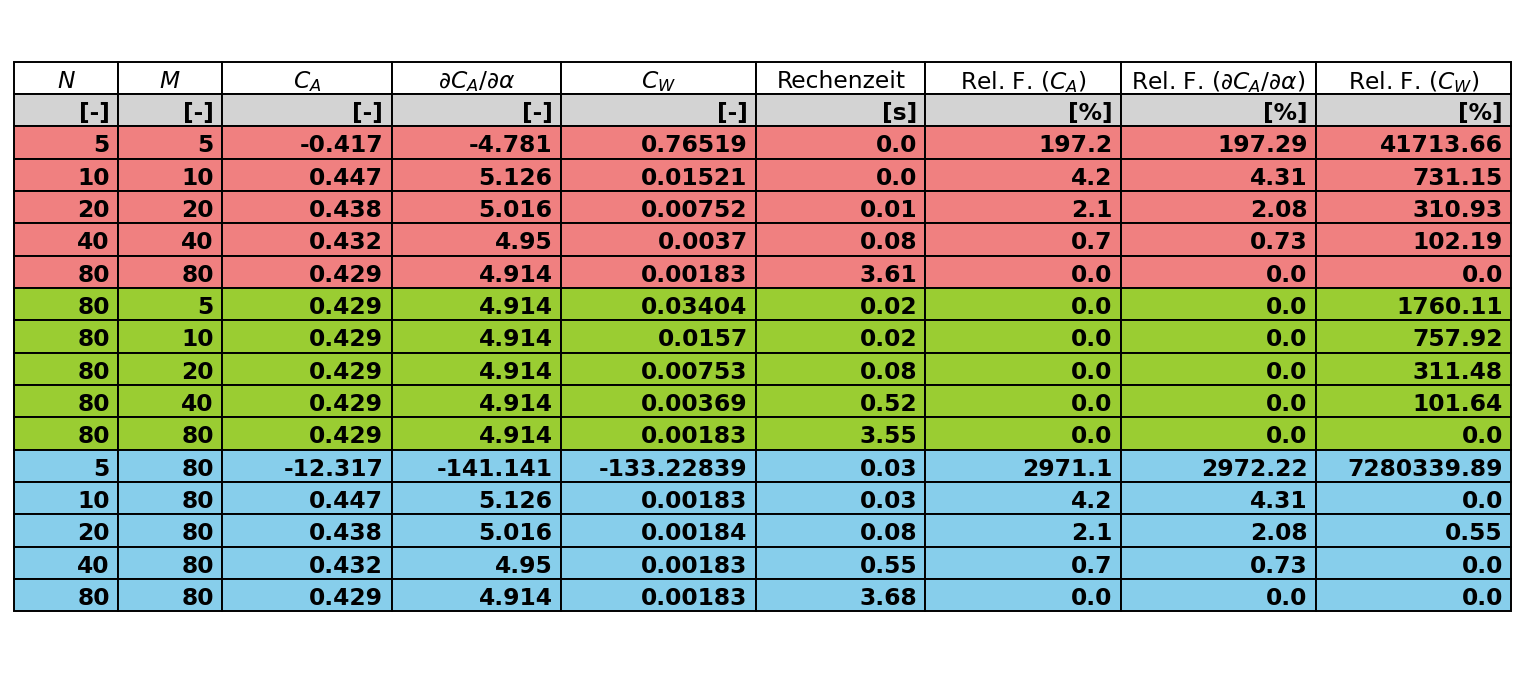

In [481]:
from blume.table import table

# Ergebnisse plotten
colColours = ["lightgray", "lightcoral", "lightcoral", "lightcoral", "lightcoral", "lightcoral", "yellowgreen", "yellowgreen", "yellowgreen", "yellowgreen", "yellowgreen", "skyblue", "skyblue", "skyblue", "skyblue", "skyblue"]

# Erstelle ein DataFrame
df = pd.DataFrame(results_dict)

# Erstelle die Tabelle
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.axis('off')
tab = table(ax, cellText=df.values, colLabels=df.columns, cellLoc='right', loc='center', colWidths= [0.08, 0.08, 0.13, 0.13, 0.15, 0.13, 0.15, 0.15, 0.15])
tab.set_fontsize(20)


# Zell-Eigenschaften anpassen
for key, cell in tab.get_celld().items():
    cell.set_height(0.05)

for col in range(9):
    for row, color in enumerate(colColours):
        tab[(row, col)].set_facecolor(color)
        tab[(row, col)].set_text_props(fontweight="heavy")

plt.show()

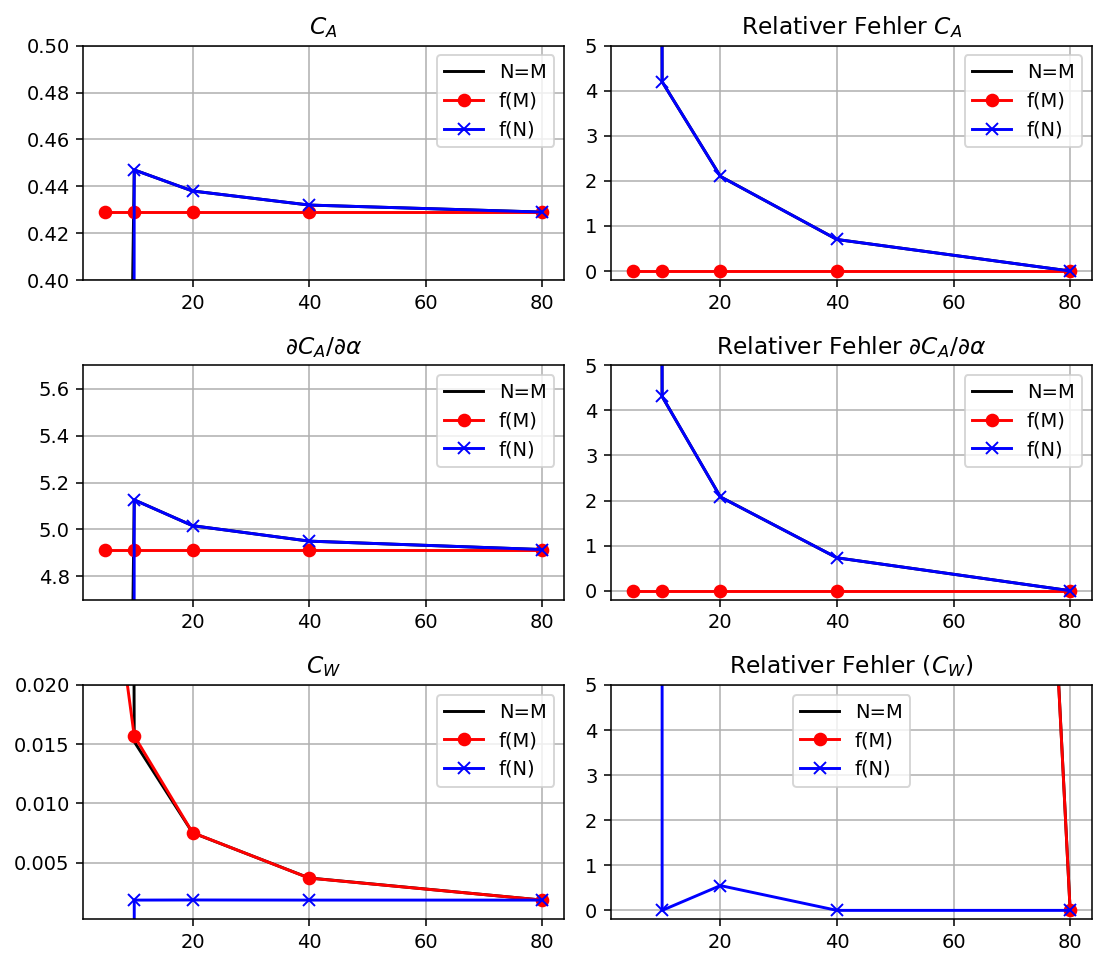

In [482]:
# plots der relativen Fehler
fig, ax = plt.subplots(3, 2, figsize=(8, 7))

# C_A
ax[0][0].plot(results_dict['$M$'][1:6], results_dict['$C_A$'][1:6], '-', label="N=M", color="black")
ax[0][0].plot(results_dict['$M$'][6:11], results_dict['$C_A$'][6:11], 'o-', label="f(M)", color="red")
ax[0][0].plot(results_dict['$N$'][11:], results_dict['$C_A$'][11:], 'x-', label="f(N)", color="blue")
ax[0][0].set_ylim([0.4, 0.5])
ax[0][0].legend()
ax[0][0].set_title(r"$C_A$")
ax[0][0].grid()

# Relativer Fehler C_A
ax[0][1].plot(results_dict['$M$'][1:6], results_dict[r'Rel. F. ($C_A$)'][1:6], '-', label="N=M", color="black")
ax[0][1].plot(results_dict['$M$'][6:11], results_dict[r'Rel. F. ($C_A$)'][6:11], 'o-', label="f(M)", color="red")
ax[0][1].plot(results_dict['$N$'][11:], results_dict[r'Rel. F. ($C_A$)'][11:], 'x-', label="f(N)", color="blue")
ax[0][1].set_ylim([-0.2, 5])
ax[0][1].legend()
ax[0][1].set_title(r"Relativer Fehler $C_A$")
ax[0][1].grid()

# dC_A/dalpha
ax[1][0].plot(results_dict['$M$'][1:6], results_dict['$\\partial C_A / \\partial \\alpha$'][1:6], '-', label="N=M", color="black")
ax[1][0].plot(results_dict['$M$'][6:11], results_dict['$\\partial C_A / \\partial \\alpha$'][6:11], 'o-', label="f(M)", color="red")
ax[1][0].plot(results_dict['$N$'][11:], results_dict['$\\partial C_A / \\partial \\alpha$'][11:], 'x-', label="f(N)", color="blue")
ax[1][0].set_ylim([4.7, 5.7])
ax[1][0].legend()
ax[1][0].set_title(r"$\partial C_A / \partial \alpha$")
ax[1][0].grid()

# Relativer Fehler dC_A/dalpha
ax[1][1].plot(results_dict['$M$'][1:6], results_dict[r'Rel. F. ($\partial C_A / \partial \alpha$)'][1:6], '-', label="N=M", color="black")
ax[1][1].plot(results_dict['$M$'][6:11], results_dict[r'Rel. F. ($\partial C_A / \partial \alpha$)'][6:11], 'o-', label="f(M)", color="red")
ax[1][1].plot(results_dict['$N$'][11:], results_dict[r'Rel. F. ($\partial C_A / \partial \alpha$)'][11:], 'x-', label="f(N)", color="blue")
ax[1][1].set_ylim([-0.2, 5])
ax[1][1].legend()
ax[1][1].set_title(r"Relativer Fehler $\partial C_A / \partial \alpha$")
ax[1][1].grid()

# dC_A/dalpha
ax[2][0].plot(results_dict['$M$'][1:6], results_dict['$C_W$'][1:6], '-', label="N=M", color="black")
ax[2][0].plot(results_dict['$M$'][6:11], results_dict['$C_W$'][6:11], 'o-', label="f(M)", color="red")
ax[2][0].plot(results_dict['$N$'][11:], results_dict['$C_W$'][11:], 'x-', label="f(N)", color="blue")
ax[2][0].set_ylim([0.0002, 0.02])
ax[2][0].legend()
ax[2][0].set_title('$C_W$')
ax[2][0].grid()

# Relativer Fehler dC_A/dalpha
ax[2][1].plot(results_dict['$M$'][1:6], results_dict[r'Rel. F. ($C_W$)'][1:6], '-', label="N=M", color="black")
ax[2][1].plot(results_dict['$M$'][6:11], results_dict[r'Rel. F. ($C_W$)'][6:11], 'o-', label="f(M)", color="red")
ax[2][1].plot(results_dict['$N$'][11:], results_dict[r'Rel. F. ($C_W$)'][11:], 'x-', label="f(N)", color="blue")
ax[2][1].set_ylim([-0.2, 5])
ax[2][1].legend()
ax[2][1].set_title(r'Relativer Fehler ($C_W$)')
ax[2][1].grid()

plt.tight_layout()
plt.show()

In [483]:
# Gitterauflösung für die folgenden Aufgaben:
N = 40
M = 80

# Paneldimensionen berechnen
Delta_y = b / N
Delta_x = c / M

### **Untersuchung des Mitteneffekts**

In [484]:
# Iterationsschleife
phi_values = list(range(-75, 76, 15))

results_dict = {
    r"$\phi$": [r"[$^\circ$]"],
    r"$C_A$": ["[-]"],
    r"$\partial C_A / \partial \alpha$": ["[-]"],
    r"$C_W$": ["[-]"],
}

for phi in phi_values:
    print(f"phi={phi}°")

    # Berechnen der Koordinaten und Trafo in Vektoren
    X_A, Y_A, X_B, Y_B, X_C, Y_C = compute_coords(s, phi, N, M, c, k_A, k_Gamma)
    x_a = matrix_to_vector(X_A)
    y_a = matrix_to_vector(Y_A)
    x_b = matrix_to_vector(X_B)
    y_b = matrix_to_vector(Y_B)
    x_c = matrix_to_vector(X_C)
    y_c = matrix_to_vector(Y_C)

    # Berechnen der Anteile der Zikrulationsmatrix
    a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c, N, M)
    a = a_AB + a_Aoo - a_Boo        
    a_ind_vec = a_Aoo - a_Boo
    Gamma_vec = np.linalg.solve(a, np.full((a.shape[0]), alpha) * (- U_inf))
    Gamma = vector_to_matrix(Gamma_vec, N, M)

    # Berechnen von Auftrieb und Auftriebsanstieg
    Gamma_span = np.sum(Gamma, axis=1) 
    A_ges = rho * U_inf * np.sum(Gamma_span * Delta_y)
    C_A = A_ges / (0.5 * rho * U_inf**2 * S)
    C_A_alpha = C_A / alpha

    # Berechnen des indzierten Widerstandes
    w_ind = vector_to_matrix(a_ind_vec @ Gamma_vec, N, M)
    W_ind = - rho * U_inf * np.sum(Gamma * w_ind * Delta_y * Delta_x)
    C_W_ind = W_ind / (0.5 * rho * U_inf**2 * S)

    results_dict[r"$\phi$"].append(phi)
    results_dict[r"$C_A$"].append(round(C_A.item(), 3))
    results_dict[r"$\partial C_A / \partial \alpha$"].append(round(C_A_alpha.item(), 3))
    results_dict[r"$C_W$"].append(round(C_W_ind.item(), 5))

phi=-75°
phi=-60°
phi=-45°
phi=-30°
phi=-15°
phi=0°
phi=15°
phi=30°
phi=45°
phi=60°
phi=75°


In [485]:
# Referenzwerte zuordnen
reference_CA = results_dict['$C_A$'][6]
reference_CA_alpha = results_dict[r"$\partial C_A / \partial \alpha$"][6]
reference_CW = results_dict['$C_W$'][6]

# Listen für Abweichung initialiseren
deviation_CA = []
deviation_CA_alpha = []
deviation_CW = []

for i in range(1, len(results_dict['$\phi$'])):
    # Abweichung: ((akt. Wert - Referenzwert) / |Referenzwert|) * 100
    deviation_CA.append(round(((abs(results_dict['$C_A$'][i] - reference_CA) / reference_CA)) * 100, 2))
    deviation_CA_alpha.append(round(((abs(results_dict[r"$\partial C_A / \partial \alpha$"][i] - reference_CA_alpha) / reference_CA_alpha)) * 100, 2))
    deviation_CW.append(round(((abs(results_dict['$C_W$'][i] - reference_CW) / reference_CW)) * 100, 2))

# Ergebnise zum results_dict hinzufügen
results_dict[r'Rel. F. ($C_A$)'] = ['[%]'] + deviation_CA
results_dict[r'Rel. F. ($\partial C_A / \partial \alpha$)'] = ['[%]'] + deviation_CA_alpha
results_dict[r'Rel. F. ($C_W$)'] = ['[%]'] + deviation_CW

<>:11: SyntaxWarning:

invalid escape sequence '\p'

<>:11: SyntaxWarning:

invalid escape sequence '\p'

/var/folders/q4/tyhs3pgs62b3cc0bq_md9h7m0000gn/T/ipykernel_26041/193909162.py:11: SyntaxWarning:

invalid escape sequence '\p'



Table axes Axes(0.125,0.11;0.775x0.77)
Axes Axes(0.125,0.11;0.775x0.77)
Same: True


<Figure size 1400x700 with 0 Axes>

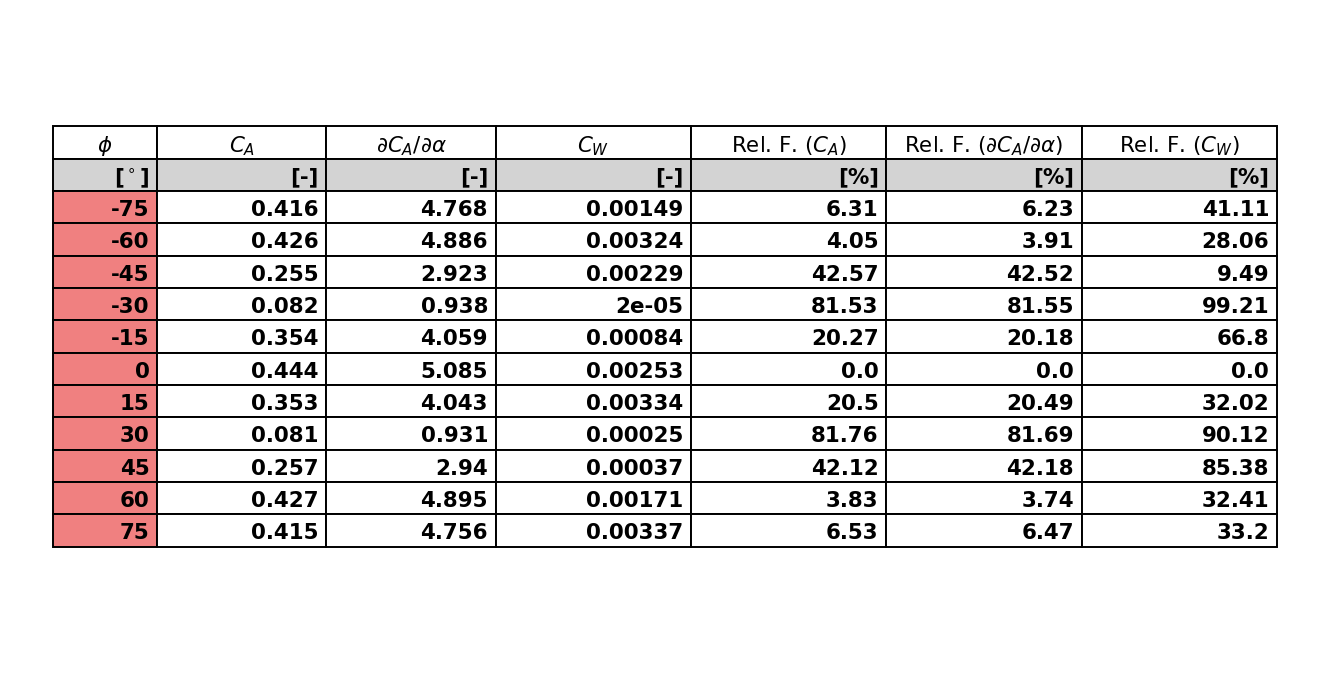

In [486]:
# Ergebnisse plotten

# Erstelle ein DataFrame
df = pd.DataFrame(results_dict)

# Erstelle die Tabelle
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.axis('off')
tab = table(ax, cellText=df.values, colLabels=df.columns, cellLoc='right', loc='center', colWidths= [0.08, 0.13, 0.13, 0.15, 0.15, 0.15, 0.15])
tab.set_fontsize(20)


# Zell-Eigenschaften anpassen
for key, cell in tab.get_celld().items():
    cell.set_height(0.05)

for col in range(7):
    for row in range(12):
        if row > 0 and col==0:
            tab[(row, col)].set_facecolor("lightcoral")
        if row == 0:
            tab[(row, col)].set_facecolor("lightgray")
        tab[(row, col)].set_text_props(fontweight="heavy")

plt.show()

## **Aufgabe 2 Theorie schlanker Körper und Theorem von Pistolesi**
Die Streckung eines Flügels hat wesentlichen Einfluss auf den Auftriebsanstieg eines Flügels. Überprüfen Sie mit dem Wirbelleiterverfahren, wie sich der Auftriebsanstieg ∂CA/∂α bei verschiedenen Streckungen Λ verändert. Weisen Sie das asymptotische Verhalten $\frac{\pi}{2} \Lambda$ für kleine Streckungen nach. Begründen Sie das Verhalten des Auftriebsanstiegs für Λ → ∞.


Für die Streckung Λ ist es empfehlenswert, die Wertereihe {0,01; 0,1; 0,2; 0,5; 1; 1,1; 2; 5; 10; 20; 50; 100} anzunehmen.



In [520]:
phi = 0
b = 10
U_inf = 30
alpha = np.radians(10)
print(alpha)
rho = 1
AR_values = [0.01, 0.1, 0.2, 0.5, 1, 1.1, 2, 5, 10, 20, 50, 100]

0.17453292519943295


In [521]:
# Iterationsschleife
phi_values = list(range(-75, 76, 15))

results_dict = {
    r"$\Lambda$": [r"[-]"],
    r"$C_A$": ["[-]"],
    r"$\frac{\partial C_A}{\partial \alpha}$": ["[-]"],
    r"$\frac{\pi}{2}\Lambda$": ["[-]"],
    r"$\frac{\partial C_A}{\partial \alpha} / \frac{\pi}{2}\Lambda$": ["[-]"],
}

# Berechnen der Koordinaten und Trafo in Vektoren
X_A, Y_A, X_B, Y_B, X_C, Y_C = compute_coords(s, phi, N, M, c, k_A, k_Gamma)
x_a = matrix_to_vector(X_A)
y_a = matrix_to_vector(Y_A)
x_b = matrix_to_vector(X_B)
y_b = matrix_to_vector(Y_B)
x_c = matrix_to_vector(X_C)
y_c = matrix_to_vector(Y_C)

# Berechnen der Anteile der Zikrulationsmatrix
a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c, N, M)
a = a_AB + a_Aoo - a_Boo        
a_ind_vec = a_Aoo - a_Boo
Gamma_vec = np.linalg.solve(a, np.full((a.shape[0]), alpha) * (- U_inf))
Gamma = vector_to_matrix(Gamma_vec, N, M)

# Berechnen von Auftrieb und Auftriebsanstieg
Gamma_span = np.sum(Gamma, axis=1) 
A_ges = rho * U_inf * np.sum(Gamma_span * Delta_y)

for AR in AR_values:
    print(f"AR={AR}")
    # Geometrische Parameter neu berechnen
    c = b/ AR
    S = b*c
    Delta_x = c / M

    C_A = A_ges / (0.5 * rho * U_inf**2 * S)
    C_A_alpha = C_A / alpha

    limit_C_A_alpha = np.pi * AR/ 2 
    ratio = C_A_alpha / limit_C_A_alpha

    results_dict[r"$\Lambda$"].append(AR)
    results_dict[r"$C_A$"].append(round(C_A.item(), 3))
    results_dict[r"$\frac{\partial C_A}{\partial \alpha}$"].append(round(C_A_alpha.item(), 3))
    results_dict[r"$\frac{\pi}{2}\Lambda$"].append(round(limit_C_A_alpha, 3))
    results_dict[r"$\frac{\partial C_A}{\partial \alpha} / \frac{\pi}{2}\Lambda$"].append(round(ratio, 6))

AR=0.01
AR=0.1
AR=0.2
AR=0.5
AR=1
AR=1.1
AR=2
AR=5
AR=10
AR=20
AR=50
AR=100


Table axes Axes(0.125,0.11;0.775x0.77)
Axes Axes(0.125,0.11;0.775x0.77)
Same: True


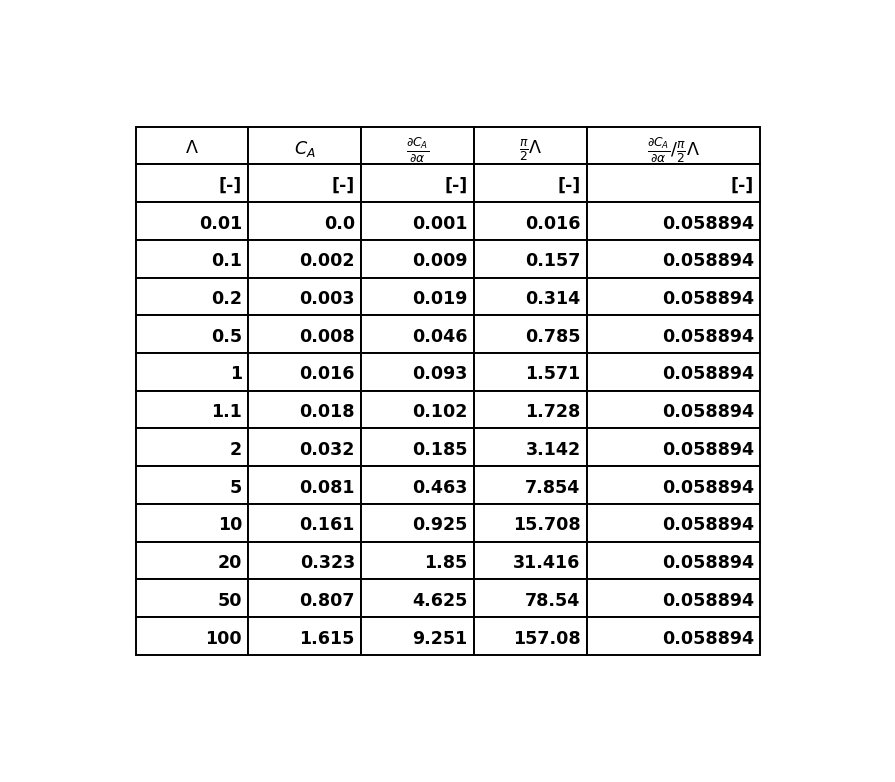

In [522]:
# Ergebnisse plotten

# Erstelle ein DataFrame
df = pd.DataFrame(results_dict)

# Erstelle die Tabelle
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1,1,1)
ax.axis('off')
tab = table(ax, cellText=df.values, colLabels=df.columns, cellLoc='right', loc='center', colWidths= [0.13, 0.13, 0.13, 0.13, 0.2])
tab.set_fontsize(20)


# Zell-Eigenschaften anpassen
for key, cell in tab.get_celld().items():
    cell.set_height(0.05)

for col in range(len(results_dict)):
    for row in range(len(results_dict[r"$\Lambda$"])):
        tab[(row, col)].set_text_props(fontweight="heavy")

plt.show()

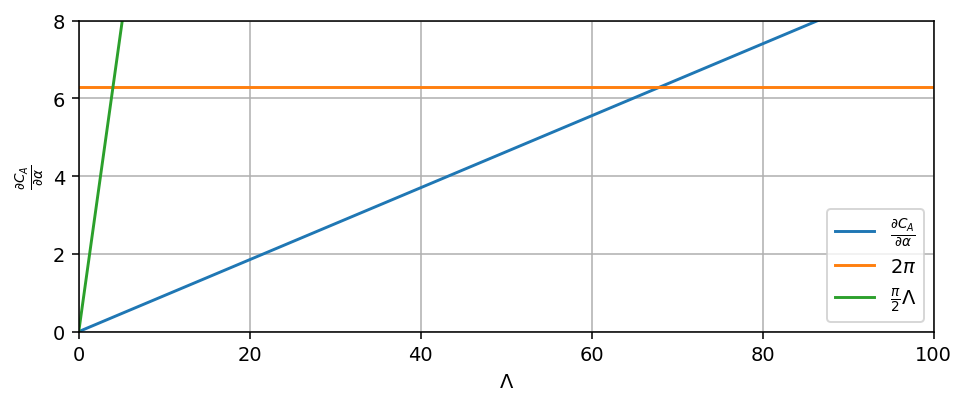

In [543]:
# Auftriebsanstieg plotten

fig = plt.figure(figsize=(7, 3))  

plt.plot(results_dict[r"$\Lambda$"][1:], results_dict[r"$\frac{\partial C_A}{\partial \alpha}$"][1:], label=r"$\frac{\partial C_A}{\partial \alpha}$")
plt.plot(results_dict[r"$\Lambda$"][1:], np.full([len(results_dict[r"$\Lambda$"][1:])], 2*np.pi), label=r"$2 \pi$")
plt.plot(results_dict[r"$\Lambda$"][1:], results_dict[r"$\frac{\pi}{2}\Lambda$"][1:], label=r"$\frac{\pi}{2}\Lambda$")

plt.legend()
plt.yscale("linear")
plt.ylim([0, 8])
plt.ylabel(r"$\frac{\partial C_A}{\partial \alpha}$")
plt.xlim([0, 100])
plt.xlabel(r"$\Lambda$")
plt.tight_layout()
plt.grid()

# Adjust layout
plt.tight_layout()